# Gold Trading Prediction with LSTM (multiple features)

What is LSTM?

LSTM = Long Short-Term Memory
LSTM networks are specially designed to remember and process sequences of data over a long period. They are better than traditional RNNs. 
*	Can preserve information for long durations. 
*	Unique structure comprising three gates: the input, forget, and output gates.
*	These gates collaboratively manage the flow of information, deciding what to retain and what to discard, by mitigating the issue of vanishing gradients, a common problem in standard RNNs.

LSTM networks adeptly capture temporal dependencies, making them ideal for financial time series analysis.


In [1]:
# import the required libraries 
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Download the gold data from the yfinace API

In [2]:
# Download the required data from yfinance
gold_one_day = yf.download('GC=F', start="2024-06-04", end="2024-06-05", interval="1m")
gold_one_year = yf.download('GC=F', period='1y')
gold_ten_year = yf.download('GC=F', period='10y')
print("Gold data are successfully downloaded.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Gold data are successfully downloaded.


## Check the data and statistics of each data frame

In [3]:
# checkout gold data for one day
gold_one_day.head(5)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-06-04 00:00:00-04:00,2366.000000,2366.399902,2365.399902,2365.899902,2365.899902,0
2024-06-04 00:01:00-04:00,2365.899902,2366.300049,2365.600098,2366.100098,2366.100098,199
2024-06-04 00:02:00-04:00,2366.000000,2366.699951,2365.800049,2366.699951,2366.699951,132
2024-06-04 00:03:00-04:00,2366.800049,2366.899902,2366.300049,2366.899902,2366.899902,56
2024-06-04 00:04:00-04:00,2366.800049,2367.100098,2366.800049,2367.000000,2367.000000,86


In [4]:
# checkout gold data for one year
gold_one_year.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-12,1959.699951,1963.500000,1951.400024,1955.300049,1955.300049,212
2023-06-13,1960.599976,1967.500000,1940.300049,1944.599976,1944.599976,343
2023-06-14,1946.199951,1958.199951,1940.300049,1955.300049,1955.300049,202
2023-06-15,1941.699951,1958.800049,1926.000000,1957.800049,1957.800049,329
2023-06-16,1961.400024,1962.900024,1953.500000,1958.400024,1958.400024,119


In [5]:
# checkout gold data for one year
gold_ten_year.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-06-12,1260.000000,1274.500000,1260.000000,1273.599976,1273.599976,129
2014-06-13,1272.500000,1274.699951,1271.300049,1273.699951,1273.699951,145
2014-06-16,1279.800049,1282.099976,1270.800049,1274.900024,1274.900024,334
2014-06-17,1272.800049,1272.800049,1260.900024,1271.699951,1271.699951,819
2014-06-18,1269.900024,1272.699951,1267.400024,1272.400024,1272.400024,143


## Check out for the missing data 

In [6]:
# check out if there is missing value 
print("Gold data one day")
print(gold_one_day.isna().sum())
print("------------------")
print("Gold data one year")
print(gold_one_year.isna().sum())
print("------------------")
print("Gold data ten years")
print(gold_ten_year.isna().sum())

Gold data one day
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
------------------
Gold data one year
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
------------------
Gold data ten years
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### There is no missing values!!! Great. Let's start building LSTM model.

## Feature Selection 

In [7]:
# Feature Selection
features = ['Open', 'High', 'Low', 'Close']

Standardize the distributed data in the range of 0 to 1. 

In [8]:
# Scaling the data
# create a dictionary which contains features' names and MinMaxScaler
scalers = {feature: MinMaxScaler(feature_range=(0, 1)) for feature in features}
# normalized the data and store them in a dictionary
gold_one_year_scaled = {feature: scalers[feature].fit_transform(gold_one_year[feature].values.reshape(-1, 1)) for feature in features}


In [9]:
gold_one_year_scaled

{'Open': array([[0.23046675],
        [0.23194099],
        [0.20835373],
        [0.20098272],
        [0.23325147],
        [0.22866499],
        [0.19099095],
        [0.16543817],
        [0.16330868],
        [0.17018841],
        [0.17690418],
        [0.15282563],
        [0.14889439],
        [0.14676491],
        [0.1619984 ],
        [0.17117117],
        [0.14791163],
        [0.15462739],
        [0.17133493],
        [0.17362817],
        [0.18558567],
        [0.23275999],
        [0.22833747],
        [0.22113022],
        [0.24537273],
        [0.25880426],
        [0.25339877],
        [0.23390671],
        [0.23963972],
        [0.21949222],
        [0.24111376],
        [0.20704345],
        [0.20720721],
        [0.22964775],
        [0.23898448],
        [0.21195745],
        [0.18869771],
        [0.18984443],
        [0.1998362 ],
        [0.1846027 ],
        [0.17428341],
        [0.16723993],
        [0.15397215],
        [0.14791163],
        [0.14250614],
  

In [10]:
# check out the scaled data size
len(gold_one_year_scaled)

5

Five features = five lists

In [11]:
# Initialize empty lists
X = []
y = []

# Loop to create a 60-day-sequence for each feature
for i in range(60, len(gold_one_year_scaled['Close'])):
    X.append([gold_one_year_scaled[feature][i-60:i, 0] for feature in features])
    y.append(gold_one_year_scaled['Close'][i, 0])

In [12]:
print(len(X))

193


In [13]:
# Train Test Split
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)



In [14]:
X_train = np.transpose(X_train, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

In [15]:
# LSTM model 
from keras.models import Model
from keras.layers import LSTM, Dense, AdditiveAttention, Permute, Reshape, Multiply, Flatten, Input, Dropout, BatchNormalization

# Define the input layer with the shape of the training data
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Add LSTM layers
lstm_out1 = LSTM(units=50, return_sequences=True)(input_layer)
lstm_out2 = LSTM(units=50, return_sequences=True)(lstm_out1)

# Permute and reshape for attention mechanism
permuted = Permute((2, 1))(lstm_out2)
reshaped = Reshape((-1, X_train.shape[1]))(permuted)

# Apply attention mechanism
attention = AdditiveAttention(name='attention_weight')([reshaped, reshaped])
attention_result = Multiply()([reshaped, attention])

# Flatten the result
flattened = Flatten()(attention_result)

# Add Dropout and Batch Normalization
dropout = Dropout(0.2)(flattened)
normalized = BatchNormalization()(dropout)

# Add a Dense output layer
output_layer = Dense(1)(normalized)



In [16]:
# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 5)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 60, 50)               11200     ['input_1[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 60, 50)               20200     ['lstm[0][0]']                
                                                                                                  
 permute (Permute)           (None, 50, 60)               0         ['lstm_1[0][0]']              
                                                                                              

In [19]:
# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, shuffle=False)

Epoch 1/100
5/5 [==============================] - 4s 220ms/step - loss: 0.0212 - val_loss: 0.0994
Epoch 2/100
5/5 [==============================] - 0s 78ms/step - loss: 0.0225 - val_loss: 0.1222
Epoch 3/100
5/5 [==============================] - 0s 81ms/step - loss: 0.0179 - val_loss: 0.2042
Epoch 4/100
5/5 [==============================] - 0s 73ms/step - loss: 0.0143 - val_loss: 0.2131
Epoch 5/100
5/5 [==============================] - 0s 73ms/step - loss: 0.0093 - val_loss: 0.1727
Epoch 6/100
5/5 [==============================] - 0s 71ms/step - loss: 0.0087 - val_loss: 0.1471
Epoch 7/100
5/5 [==============================] - 0s 77ms/step - loss: 0.0114 - val_loss: 0.1606
Epoch 8/100
5/5 [==============================] - 0s 73ms/step - loss: 0.0113 - val_loss: 0.1812
Epoch 9/100
5/5 [==============================] - 0s 78ms/step - loss: 0.0101 - val_loss: 0.1806
Epoch 10/100
5/5 [==============================] - 0s 77ms/step - loss: 0.0092 - val_loss: 0.1714
Epoch 11/100
5/5 [

In [20]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

2/2 [==============================] - 0s 9ms/step - loss: 0.2359
Test Loss:  0.23587970435619354


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

2/2 [==============================] - 1s 9ms/step
Mean Absolute Error:  0.4771438762844805
Root Mean Square Error:  0.48567448219568904


In [22]:
# Scaling the data for the latest predictions
scaled_data = {feature: scalers[feature].transform(gold_one_year[feature].values.reshape(-1, 1)) for feature in features}

# Prepare the input data for the latest 60 days
X_latest = np.array([[scaled_data[feature][-60:].reshape(60) for feature in features]])
X_latest = np.transpose(X_latest, (0, 2, 1))

# Make a prediction for the next day
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scalers['Close'].inverse_transform(predicted_stock_price)
print("Predicted Stock Price for tomorrow: ", predicted_stock_price)



1/1 [==============================] - 0s 22ms/step
Predicted Stock Price for tomorrow:  [[2111.131]]


In [23]:
# Predict the next 4 days iteratively
predicted_prices = []
current_batch = np.transpose(np.array([[scaled_data[feature][-60:].reshape(60) for feature in features]]), (0, 2, 1))

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)
    
    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = np.array([[[next_prediction[0, 0]]] * len(features)]).reshape(1, 1, len(features))
    
    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    
    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scalers['Close'].inverse_transform(next_prediction)[0, 0])

print("Predicted Gold Prices for the next 4 days: ", predicted_prices)

1/1 [==============================] - 0s 22ms/step
Predicted Gold Prices for the next 4 days:  [2111.131, 2118.7373, 2129.6233, 2140.6475]


In [24]:
# Fetching the latest 60 days of gold data
test_data = yf.download('GC=F', period='1y')

[*********************100%%**********************]  1 of 1 completed


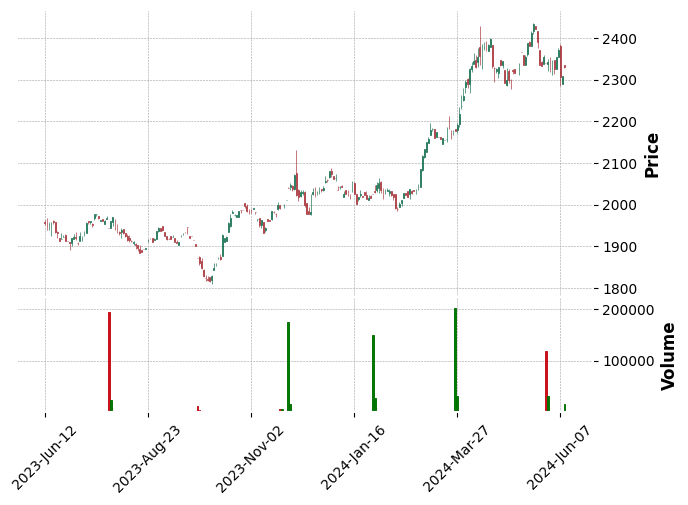

Text(0.5, 1.0, 'Gold Price with Predicted Next 4 Days')

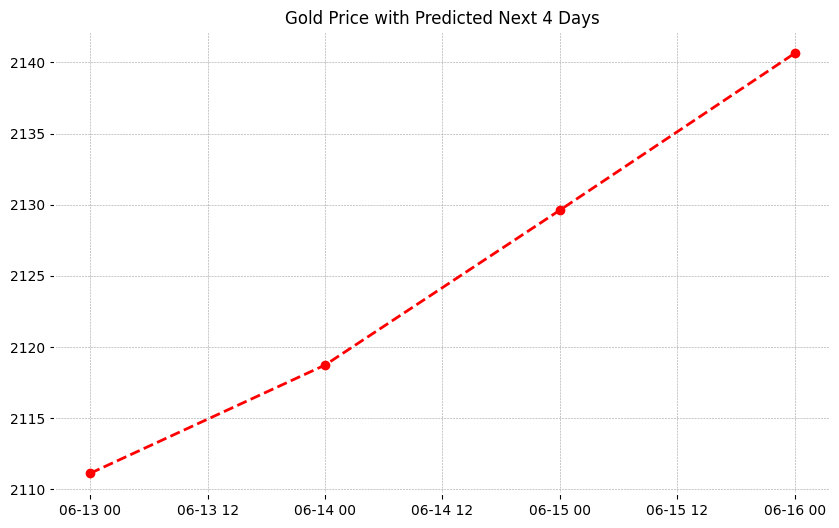

In [25]:
!pip install mplfinance -qqq
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = test_data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(test_data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("Gold Price with Predicted Next 4 Days")

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


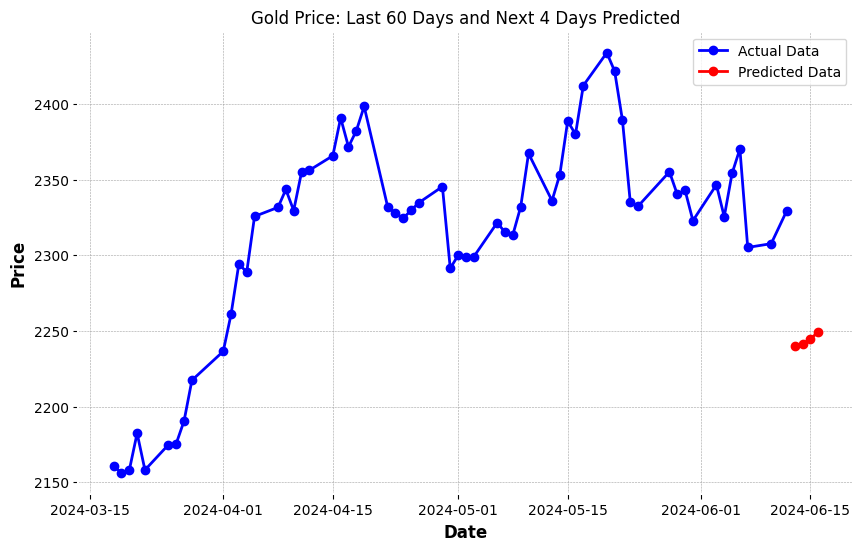

In [26]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 3 months of gold data
data = yf.download('GC=F', period='3mo', interval='1d')

# Select features and scale them
features = ['Open', 'High', 'Low', 'Close', 'Volume']
scalers = {feature: MinMaxScaler(feature_range=(0, 1)) for feature in features}
scaled_data = {feature: scalers[feature].fit_transform(data[feature].values.reshape(-1, 1)) for feature in features}

# Prepare the input data for the latest 60 days
X_latest = np.array([[scaled_data[feature][-60:].reshape(60) for feature in features]])
X_latest = np.transpose(X_latest, (0, 2, 1))

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = np.transpose(np.array([[scaled_data[feature][-60:].reshape(60) for feature in features]]), (0, 2, 1))

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = np.array([[[next_prediction[0, 0]]] * len(features)]).reshape(1, 1, len(features))
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scalers['Close'].inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:]  # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("Gold Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [27]:
# Save the model
model.save("gold_price_prediction_model.h5")

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model("gold_price_prediction_model.h5")